* How were Lyapunov exponents calculated for PSR state?
* What type of limit cycle attracts from inside but repels from outside?

In [2]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
class Parameters(object):
    def __init__(self, **kwargs):
        self.eta_center = kwargs['eta_center']
        self.eta_spread = kwargs['eta_spread']
        self.k_center = kwargs['k_center']
        self.k_spread = kwargs['k_spread']

# Defines the three parameters sets from the paper Luke et al. 2013
psr = Parameters(eta_center = -0.2,  eta_spread = 0.1, k_center = -2.0, k_spread = 0.0)
pss = Parameters(eta_center = 0.2,   eta_spread = 0.1, k_center = 2.0,  k_spread = 0.0)
cpw = Parameters(eta_center = 10.75, eta_spread = 0.5, k_center = -9.0, k_spread = 0.0)

In [4]:
def get_cauchy_distribution(center, spread, N):
    return center + spread * np.tan(np.pi * (np.random.rand(N) - 0.5))

def run_integration(f, x0, t0, t1, dt):

    r = integrate.ode(f).set_integrator('dopri5')
    r.set_initial_value(x0, t0)
    
    t = []
    y = []
    
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        t.append(r.t)
        y.append(r.y)
    return t,y

There are two models to consider. The first is discrete, the other considers the case where $N = \infty$. Amazingly, the dynamics can be reduced to a two dimensional system. This implies chaos is not possible in the infinite chaos. The OA manifold is the name of this lower dimesional system.

In [5]:
class Model(object):
    def __init__(self):
        self.x = []
        self.y = []
        self.t = []

class DiscreteModel(Model):
    def __init__(self, params, N, **kwargs):
        self._params = params
        self._N = N
        self._is_autapse = kwargs.get("is_autapse", True)
        
        if kwargs.get("theta0") != None:
            self._theta0 = kwargs.get("theta0")
        else:
            self._theta0 = 2.0 * np.pi * np.random.rand(N)
            
        if kwargs.get("eta") != None:
            self.eta = kwargs.get("eta")
        else:
            self.eta = get_cauchy_distribution(params.eta_center, params.eta_spread, N)
        
        self.k = get_cauchy_distribution(params.k_center, params.k_spread, N)
        
        # If present, then with probability p, set some of the synaptic strengths to 0
        if kwargs.get("p") != None:
            self._k = [0.0 if np.random.rand() < kwargs.get("p") else self._k[i] for i in range(N)]
        
        self._an = 2.0/3.0

    def f(self, t, theta):
        all_pulses = (1.0 - np.cos(theta))**2
        if self._is_autapse:
            Isyn = np.sum(all_pulses)
        else:
            Isyn = np.sum(all_pulses) * np.ones(self._N) - all_pulses
        return (1.0 - np.cos(theta)) + (1.0 + np.cos(theta))*(self.eta + self._an * self.k * Isyn / self._N)
    
    def run(self, t1, dt):
        self.x = []
        self.y = []
        self.t,data = run_integration(self.f, self._theta0, 0.0, t1, dt)
        for row in data:
            self.x.append(np.sum(np.cos(row))/self._N)
            self.y.append(np.sum(np.sin(row))/self._N)

class ReducedModel(Model):
    def __init__(self, params):
        self._x0 = 0.0
        self._y0 = 0.0
        self._params = params
        self._A0 = 3.0/2.0
        self._A1 = -1.0
        self._A2 = 1.0/4.0
        self._an = 2.0/3.0
        
    def f(self, t, r):
        x = r[0]
        y = r[1]
        H = self._an * (self._A0 + self._A1 * 2.0*x + self._A2 * 2.0*(x**2 - y**2))
        
        eta0    = self._params.eta_center
        k_delta = self._params.k_spread
        eta_delta = self._params.eta_spread
        k0 = self._params.k_center
        
        delta = (eta_delta + k_delta * H)
        Fx = (x - 1.0)*y - 0.5 * delta * ((x+1)**2 - y**2) - (x+1)*y*(eta0 + k0*H)
        Fy = -0.5*((x-1)**2 - y**2) - (x+1)*y*delta + 0.5*((x+1)**2 - y**2)*(eta0 + self._params.k_center*H)
        return [Fx, Fy]
    
    def run(self, t1, dt):
        self.x = []
        self.y = []
        self.t,data = run_integration(self.f, [self._x0, self._y0], 0.0, t1, dt)
        for row in data:
            self.x.append(row[0])
            self.y.append(row[1])

<br/><br/><br/><br/><br/><br/><br/><br/><br/>
# CPW: Continous Periodic Wave

In [98]:
"""
How many neurons does it take to maintain limit cycle?
What is the probability of equilibrium as a function of N?


N = 100
The discrete network sees to always approach equilibrium at:
(-0.75057739759,-0.616625272657)
(-0.749313726386,-0.593987397011)

"""
N_cpw = 1
dt = 0.01
t = 30.0
#print 2.0 * np.pi * np.random.rand(N_cpw)

rm_cpw = ReducedModel(cpw)
dm_cpw = DiscreteModel(cpw,N_cpw,is_autapse=True,theta0=[0.0],eta=[1.5])
rm_cpw.run(t,dt)
dm_cpw.run(t,dt)

Now we look at the dynamics of one spiking neuron

What do spikes look like over time?
TODO:
Plots that show different neurons spiking over time

Plot that shows phase of neurons over time

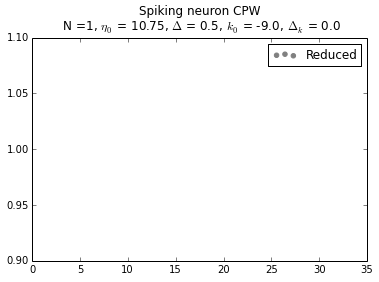

In [99]:
angles = []
for i in range(len(dm_cpw.x)):
    y = dm_cpw.y[i]
    x = dm_cpw.x[i]
    angle = np.arctan(np.abs(y/x))
    
    # Upper left quadrant
    if y > 0 and x < 0:
        angle += np.pi / 2.0
    elif y < 0 and x < 0:
        # Bottom left quadrant
        angle += np.pi
    elif y < 0 and x > 0:
        angle += np.pi * 3.0/2.0
    angles.append(angle)
    
spikes = [0]
for i in range(1, len(angles)):
    if angles[i-1] < np.pi and angles[i] > np.pi:
        spikes.append(1)
    elif angles[i-1] > np.pi and angles[i] < np.pi:
        spikes.append(1)
    else:
        spikes.append(0)
plt.title("Spiking neuron CPW \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_cpw, cpw.eta_center, cpw.eta_spread, cpw.k_center, cpw.k_spread))
plt.scatter(dm_cpw.t,spikes,color="gray", label="Reduced", marker='o')
plt.ylim([0.9, 1.1])
plt.xlim(0.0)
plt.legend()

(-0.95572908005,0.294248068043)


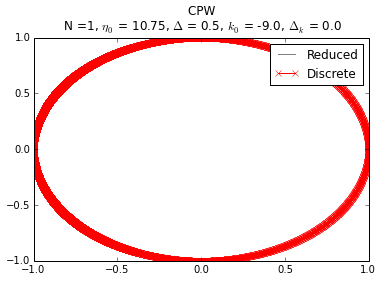

In [8]:
print '({0},{1})'.format(dm_cpw.x[-1], dm_cpw.y[-1])

plt.title("CPW \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_cpw, cpw.eta_center, cpw.eta_spread, cpw.k_center, cpw.k_spread))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])

plt.plot(rm_cpw.x[-300:],rm_cpw.y[-300:],color="gray", label="Reduced")
plt.plot(dm_cpw.x[:],dm_cpw.y[:],color="red", label="Discrete",marker='x')
plt.legend()

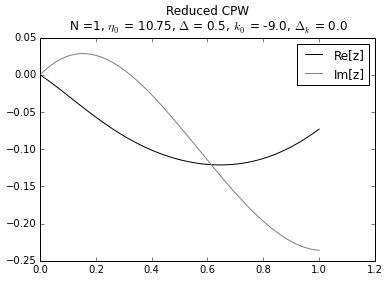

In [9]:
plt.title("Reduced CPW \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_cpw, cpw.eta_center, cpw.eta_spread, cpw.k_center, cpw.k_spread))
plt.plot(rm_cpw.t,rm_cpw.x,color="black",label="Re[z]")
plt.plot(rm_cpw.t,rm_cpw.y,color="gray",label="Im[z]")
plt.legend()

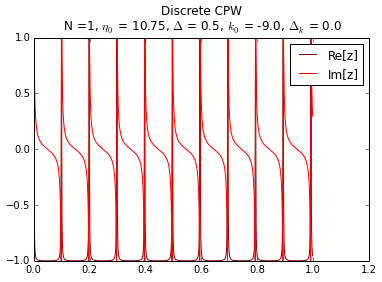

In [10]:
plt.title("Discrete CPW \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_cpw, cpw.eta_center, cpw.eta_spread, cpw.k_center, cpw.k_spread))
plt.plot(dm_cpw.t,dm_cpw.x,color="darkred",label="Re[z]")
plt.plot(dm_cpw.t,dm_cpw.y,color="red",label="Im[z]")
plt.legend()

<br/><br/><br/><br/><br/><br/><br/><br/><br/>
# PSS: Partially Sychronous State

In [11]:
N_pss = 10000
dt = 0.01
t = 50.0

rm_pss = ReducedModel(pss)
dm_pss = DiscreteModel(pss,N_pss,0.5)

rm_pss.run(t,dt)
dm_pss.run(t,dt)

TypeError: __init__() takes exactly 3 arguments (4 given)


<br/>Now, we check the distribution of $\eta$ which should be of Cauchy form

In [ ]:
plt.hist(dm_pss.eta, bins=40, normed=True, color="gray", histtype="step", range=[-2., 2.])
plt.title('$\eta$')

Now, we check the distribution of $k$ which should be of Cauchy form

In [ ]:
plt.hist(dm_pss.k, bins=40, normed=True, color="gray", histtype="step", range=[1., 3.])
plt.title('$k$')

In [ ]:
print 'Paper Prediction: x = [-0.2815, -0.2415], y = [-0.0250, 0.0150]'
print 'Final Discrete Coordinate: ({0},{1})'.format(dm_pss.x[-1], dm_pss.y[-1])
print 'Final Reduced Coodinate: ({0},{1})'.format(rm_pss.x[-1], rm_pss.y[-1])
plt.title("PSS \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_pss, pss.eta_center, pss.eta_spread, pss.k_center, pss.k_spread))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.plot(rm_pss.x,rm_pss.y,color="gray", label="Reduced")
plt.plot(dm_pss.x,dm_pss.y,color="red", label="Discrete")
plt.legend()

In [ ]:
plt.title("Reduced PSS \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_pss, pss.eta_center, pss.eta_spread, pss.k_center, pss.k_spread))
plt.plot(rm_pss.t,rm_pss.x,color="black",label="Re[z]")
plt.plot(rm_pss.t,rm_pss.y,color="gray",label="Im[z]")
plt.legend()

In [ ]:
plt.title("Discrete PSS \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_pss, pss.eta_center, pss.eta_spread, pss.k_center, pss.k_spread))
plt.plot(dm_pss.t,dm_pss.x,color="darkred",label="Re[z]")
plt.plot(dm_pss.t,dm_pss.y,color="red",label="Im[z]")
plt.legend()

<br/><br/><br/><br/><br/><br/><br/><br/><br/>
# PSR: Partially Sychronous Rest

In [ ]:
N_psr = 10000
dt = 0.01
t = 5.0
rm_psr = ReducedModel(psr)
dm_psr = DiscreteModel(psr,N_psr,0.5)
rm_psr.run(t,dt)
dm_psr.run(t,dt)

In [ ]:
plt.hist(dm_psr.eta, bins=40, normed=True, color="gray", histtype="step", range=[-2., 2.])
plt.title('$\eta$')

In [ ]:
plt.hist(dm_pss.k, bins=40, normed=True, color="gray", histtype="step", range=[-2., 2.])
plt.title('$k$')

In [ ]:
# Plots results
print 'Paper Prediction: x = [-0.5360, -0.5300], y = [-0.8345, -0.8285]'
print 'Final Discrete Coordinate: ({0},{1})'.format(dm_psr.x[-1],dm_psr.y[-1])
print 'Final Reduced Coodinate: ({0},{1})'.format(rm_psr.x[-1],rm_psr.y[-1])
plt.title("PSR \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_psr, psr.eta_center, psr.eta_spread, psr.k_center, psr.k_spread))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.plot(rm_psr.x,rm_psr.y,color="gray", label="Reduced")
plt.plot(dm_psr.x,dm_psr.y,color="red", label="Discrete")
plt.legend()

In [ ]:
plt.title("Reduced PSR \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_psr, psr.eta_center, psr.eta_spread, psr.k_center, psr.k_spread))
plt.plot(rm_psr.t,rm_psr.x,color="black",label="Re[z]")
plt.plot(rm_psr.t,rm_psr.y,color="gray",label="Im[z]")
plt.legend()

In [ ]:
plt.title("Discrete PSR \n N ={0}, $\eta_0$ = {1}, $\Delta$ = {2}, $k_0$ = {3}, $\Delta_k$ = {4}".format(N_psr, psr.eta_center, psr.eta_spread, psr.k_center, psr.k_spread))
plt.plot(rm_psr.t,rm_psr.x,color="darkred",label="Re[z]")
plt.plot(rm_psr.t,rm_psr.y,color="red",label="Im[z]")
plt.legend()